# Machine Learning phases of matter

## Abstract
This project aims to reobtain the results presented in [Machine learning phases of matter (Juan Carrasquilla, Roger G. Melko)](https://arxiv.org/abs/1605.01735) regarding the two-dimensional square Ising model. The authors show that a standard _feed-forward neural network_ (FFNN) is a suitable tool to detect Ising's model phase transition.  
This is done by first comparing the behavior of a _fully connected neural networr_ (FCNN) to a hand-made Toy model.  
Then the number of parameters of the FCNN is increased and the accuracy of the model is studied as a function of the lattice size to remove boundary effects.   In the original article, the FCNN is then upgraded to a _convolutional neural network_ to test its accuracy on non-Ising Hamiltonians.  
Finally, as an appendix, the original data is analyzed with the _t-stochastic neighbors embedding_ algorithm to separate the data into clusters.

The full project can be found on GitHub: [https://github.com/NerusSkyhigh/Machine-Learning-Phases-of-Matter](https://github.com/NerusSkyhigh/Machine-Learning-Phases-of-Matter).

---

In this third notebook Toy model FCNN will be upgraded with an hidden layer of 100 neurons, then the training procedure will be discussed in detail. Following that, the results of [Juan Carrasquilla and Roger G. Melko](https://arxiv.org/abs/1605.01735) on non standard Ising hamiltonian will be presented.

In [ ]:
!rm -rf sample_data Machine-Learning-Phases-of-Matter MonteCarloSampling data.csv
!git clone https://github.com/NerusSkyhigh/Machine-Learning-Phases-of-Matter

# Compile C source codes
!gcc -Wall Machine-Learning-Phases-of-Matter/MonteCarloSampling.c -o MonteCarloSampling.o -lm

Cloning into 'Machine-Learning-Phases-of-Matter'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 135 (delta 59), reused 106 (delta 33), pack-reused 0
Receiving objects: 100% (135/135), 3.40 MiB | 4.97 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [ ]:
#@markdown Load libraries and helper functions
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(rc={'figure.figsize':(22,6)}, style='darkgrid')

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nUsing {device} device")

# CONSTANTS
critical_temperature = 2/( np.log( np.sqrt(2)+1) )

# FUNCTIONS
def generate_data(lowest_temperature, increment_temperature, highest_temperature,
                  lattice_side, number_of_configurations,
                  initial_number_of_thermalisation_steps, number_of_thermalisation_steps,
                  filename='data.csv', clear_old_data=True, show_termalisation_info=False):
  # ! This version supports the "initial_number_of_thermalisation_steps" parameter
  debug_flag = "" if show_termalisation_info else "1>/dev/null"
  clear_flag = f"rm -rf {filename}" if clear_old_data else ""

  sh = f"""
  set -e
  export LC_NUMERIC="en_US.UTF-8"

  {clear_flag}

  for T in $(seq {lowest_temperature} {increment_temperature} {highest_temperature})
  do
    ./MonteCarloSampling.o --lattice-side {lattice_side} \
                          --temperature $T \
                          --number-of-configurations {number_of_configurations} \
                          --initial_thermalisation-steps {initial_number_of_thermalisation_steps} \
                          --thermalisation-steps {number_of_thermalisation_steps} \
                          --output-file '{filename}' {debug_flag}
  done
  """
  with open('script.sh', 'w') as file:
    file.write(sh)

  !bash script.sh && rm script.sh

def dataframe_from_lattice_csv(fileName, lattice_side):
  df = pd.read_csv(fileName, names=['L', 'T', 'E']+['LP'+str(i) for i in range(lattice_side*lattice_side)] )

  df['lattice'] = df[df.columns[3:]].apply( lambda x: np.array(x, dtype=np.float32), axis=1)
  df = df.drop(columns=['L']+['LP'+str(i) for i in range(lattice_side*lattice_side)])
  df['magnetization']  = df['lattice'].apply(lambda x: x.sum()/x.shape[0])

  return df



Using cuda device


## 03 - The Network in detail

### The improved FCNN
The Toy Model shows unstable training mainly due to the small number of neurons in the hidden layer. As suggested by the authors the network will be improved by increasing the number of neurons in the hidden layer to $100$. This results in both a _faster_ and _more stable_ training.

In [ ]:
#@markdown Data Generation
lowest_temperature = 1 #@param {type:"number"}
highest_temperature = 3.51 #@param {type:"number"}
increment_temperature = 0.05 #@param {type:"number"}
lattice_side = 30 #@param {type:"integer"}
number_of_configurations = 1000 #@param {type:"integer"}
initial_number_of_thermalisation_steps = 2000 #@param {type:"integer"}
number_of_thermalisation_steps = 500 #@param {type:"integer"}
# number_of_thermalisation_steps = 4000

filename = "FCNN_data.csv"
generate_data(lowest_temperature, increment_temperature, highest_temperature,
              lattice_side, number_of_configurations,
              initial_number_of_thermalisation_steps, number_of_thermalisation_steps,
              filename, clear_old_data=True, show_termalisation_info=False)

print(f"Data Generation completed. The files are available in {filename}.")

Data Generation completed. The files are available in FCNN_data.csv.


In [ ]:
from sklearn.model_selection import train_test_split

df = dataframe_from_lattice_csv(filename, lattice_side)

# Input data are just the lattice sites
X = np.empty( (df['lattice'].shape[0], lattice_side*lattice_side), dtype=np.float32 )
for idx, lattice in enumerate(df['lattice']):
  X[idx] = lattice

# Y should be [0., 1.] if T>Tc or [1., 0] otherwise.
Y = np.empty( (df.shape[0], 2), dtype=np.float32)
for idx, T in enumerate(df['T']):
  Y[idx] = [0., 1.] if T>critical_temperature else [1., 0]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, shuffle=True)

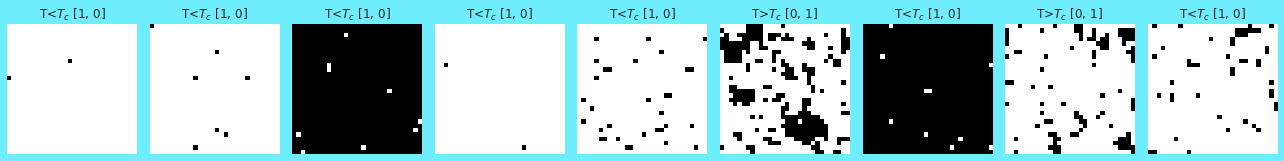

In [ ]:
#@markdown Nine configurations with their label picked at random.
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(18, 8))
fig.patch.set_facecolor('xkcd:robin\'s egg')

for ax in axs:
  sample_idx = int(np.random.rand()*len(X_train))
  img, label = X_train[sample_idx], Y_train[sample_idx, :]
  ax.set_title(r"T{}$T_c$ [{}, {}]".format('>' if label[1] else '<',
                                          int(label[0]),
                                          int(label[1]) ))
  ax.axis("off")
  ax.imshow(img.reshape( (lattice_side, lattice_side) ), interpolation='none',
            cmap="gray")

plt.tight_layout()
plt.show();

In [ ]:
from torch import nn

class NeuralNetwork(nn.Module):  
  def __init__(self):
    super(NeuralNetwork, self).__init__()

    self.layers = nn.Sequential(
      nn.Linear(lattice_side*lattice_side, 100, bias=True),
      nn.Sigmoid(),
      nn.Linear(100, 2, bias=False),
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.layers(x)

  
  def predict(self, x):
    output = self.forward(x)
    return torch.argmax(output, 1)

#####################################


def train(model, X, y, epochs):
  # The Cross Entropy Loss is suitable for classification problems
  loss_function = nn.BCELoss()

  # Create an optimizer that will be used to train the network.
  # Weight decay handles the L2 regularizator
  learning_rate = 1e-2
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=2e-05)
  
  # List of losses for visualization
  losses = []

  for i in range(epochs):
    y_pred = model.forward(X)
    loss = loss_function(y_pred, y)

    # Clear the previous gradients and compute the new ones
    optimizer.zero_grad()
    loss.backward()

    # Adapt the weights of the network
    optimizer.step()

    # Store the loss
    losses.append(loss.item())

  return losses

Test loss: 0.025237474590539932 



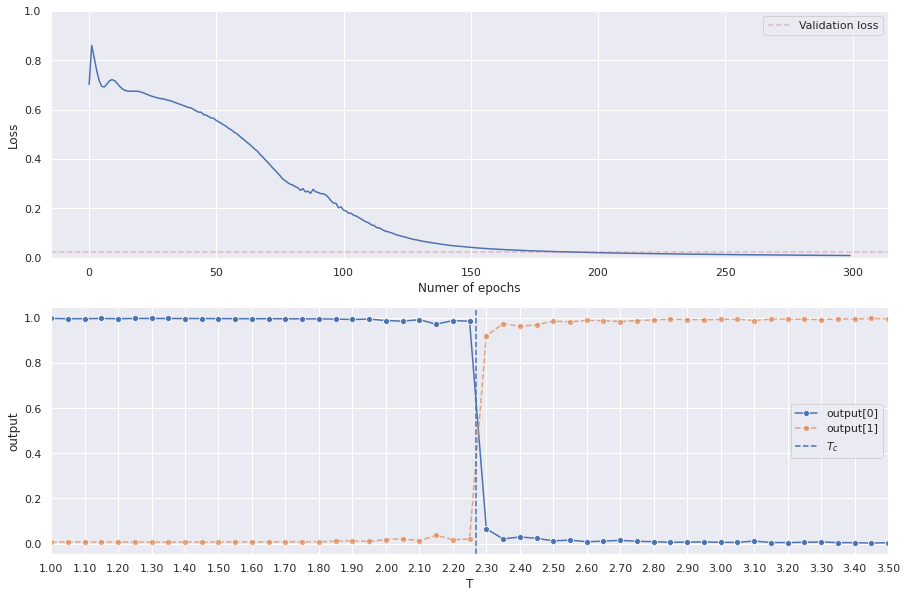

In [ ]:
#@markdown Results of the upgraded network

# Convert the 2D points to a float32 tensor
X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train_torch = torch.from_numpy(Y_train).to(device)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test_torch = torch.from_numpy(Y_test).to(device)

# Generate and train the model
model = NeuralNetwork().to(device)
losses = train(model, X_train_torch, Y_train_torch, epochs=300)

# Test the model
Y_pred = model.forward(X_test_torch)
loss = nn.BCELoss()(Y_pred, Y_test_torch)
print("Test loss:", loss.item(), "\n")


# Plots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
axs[0].plot(np.arange( len(losses) ), losses);
axs[0].axhline(y=loss.item(), color='r', linestyle='--', alpha=0.3, label="Validation loss")
axs[0].legend()
axs[0].set_ylim([0, 1])
axs[0].set_ylabel("Loss")
axs[0].set_xlabel("Numer of epochs");


X_torch = torch.tensor(X, dtype=torch.float32).to(device)
Y_pred = model.forward(X_torch)
Y_detached = Y_pred.cpu().detach().numpy()

sns.lineplot(x=df['T'], y=Y_detached[:, 0], ax=axs[1], label=r"output[0]", marker="o", ci=None)
sns.lineplot(x=df['T'], y=Y_detached[:, 1], ax=axs[1], label=r"output[1]", marker="o", ci=None, alpha=0.7, linestyle='--')
axs[1].axvline(critical_temperature, 0, 1, label=r"$T_c$", linestyle="--")

xticks = np.arange(lowest_temperature, highest_temperature, 2*increment_temperature)
axs[1].set_xticks(xticks)
axs[1].set_xticklabels(['{:.2f}'.format(T) for T in xticks])
axs[1].legend()
axs[1].set_xlim([1, 3.5])
axs[1].set_ylabel("output");

It is possible to see similar results with more consistent training. The only downside is that it is difficult to keep track of all the $100$ hidden neurons and the actual inner working of the network is unknown.

### Discussion

#### The network
```python
class NeuralNetwork(nn.Module):  
  def __init__(self):
    super(NeuralNetwork, self).__init__()

    self.layers = nn.Sequential(
      nn.Linear(lattice_side*lattice_side, 100, bias=True),
      nn.Sigmoid(),
      nn.Linear(100, 2, bias=False),
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.layers(x)
```
As already stated multiple times, the network consists of $L^2$ input neurons, $100$ hidden neurons, and two sigmoid activation functions. The first layer is biased, while the second is not. No significant difference was found in biasing the second layer. For consistency with the Toy Model, the second layer was kept unbiased.

</br> 


#### The training phase
The training phase is the core of each machine learning application and a lot of care is required. Each part of the training phase will be discussed.

```python
def train(model, X, y, epochs):
  # The Cross Entropy Loss is suitable for classification problems
  loss_function = nn.BCELoss() # nn.CrossEntropyLoss()
```
The **loss function** is the machine learning equivalent of the error, to the point where regression problems use the mean square error $MSE=\frac{1}{N}\sum_{i}(y^{predicted}_{i}-y^{expected}_{i})$ as loss function.  
The authors of the article claim to have used a _"cross-entropy cost function"_ but little to no result was obtained by using it. What is most likely to have happened is that the authors used a _**Binary** Cross Entropy cost function_, a version of the cross entropy suitable for binary classification problems. Given $N$ datapoints subdivided into two classes $y = \{ 0, 1\}$ it is possible to compute the binary cross entropy of the probability $p(y_i)$ that the point $i$ belongs to the class $y = 1$ as:

$$H_p(q) = - \frac{1}{N} \sum_{i=1}^{N} y_i \log\left(p(y_i)\right) + (1-y_i) \log\left(1-p(y_i)\right)$$

Notice that the requirement $y = \{ 0, 1\}$ implies that the two terms in the sum are mutually exclusive and the binary cross entropy could be rewritten as:
$$H_p(q) = - \frac{1}{N} \sum_{y\in\{0, 1\}}\sum_{i=1}^{N_{y}} \log\left(p(y_i)\right)$$
That is the sum of the logarithmic probability that each point belongs to the correct class.

</br> 

```python
  # Create an optimizer that will be used to train the network.
  # Weight decay handles the L2 regularizator
  learning_rate = 1e-2
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=2e-05)
```
The optimizer chosen by the authors is the Adam optimizer whose algorithm is shown in the following image taken from the [original article](https://arxiv.org/abs/1412.6980).

![](https://i.ibb.co/bXHV3fF/03-adam-optimizer.png)

The algorithm is a "first-order gradient-based optimization" with moments. An in-depth discussion of momentum is out of scope, but the gist is that the step size depends on the value of the gradient so that the optimizer can easily leave local minima.  
The learning rate is a multiplicative constant that further reduces the step size to avoid overshooting the true minimum. When the matrix involved is _not_ sparse it works as a cap to the maximum step size.  
The weight decay takes the place of the $L^2$ regularizator suggested in the article. Instead of adding a penalization term $\lambda \sum_{i} w_i^2$ to the cost function, the weights decay with a characteristic constant, effectively discouraging large weight magnitudes.

</br> 

```python 
  # List of losses for visualization
  losses = []

  for i in range(epochs):
    y_pred = model.forward(X)
    loss = loss_function(y_pred, y)

    # Clear the previous gradients and compute the new ones
    optimizer.zero_grad()
    loss.backward()

    # Adapt the weights of the network
    optimizer.step()

    # Store the loss
    losses.append(loss.item())

  return losses
```
The training loop works in a straightforward way:  
  1. Predictions for the input data are computed using the current state of the model
  2. The loss is computed by taking the binary cross entropy of the data
  3. The gradient is set to zero and the new gradient is computed. This behavior is due to Pytorch's internal implementation of the Autograd algorithm.
  4. A step of the optimizer is performed using the new gradient

The number of epochs is not known a priori, the correct value is usually discovered by trial and error by analyzing the performances of the network.

### Applications to non-standard Ising Hamiltonian
The authors then proceed in testing the network on non-ferromagnetic square lattice Ising hamiltonian:

</br>

#### Anti-ferromagnetic coupling
$$ H = J \sum_{<ij>}\sigma_{i}^z\sigma_{j}^z$$
The network performs optimally and is able to perform similarly to the ferromagnetic case even though providing less theoretical understanding.

</br>

#### Triangular Lattice Ferrogmagnetic Ising Model
The network trained on the **square** lattice Ising model is tested against configurations sampled from a **triangular** lattice ferromagnetic Ising Hamiltonian.
The authors don't say anything about data preprocessing to make a triangular configuration compatible with square configurations, but I think some kind of transformation was required. The performances of the network are reported in the following image taken from the article:  

![](https://i.ibb.co/QbDc5qx/02-triangular-ising.png)

The network is capable of correctly identifying the critical temperature for a lattice of size $L=30$ within a $0.14\%$ error. The esteem of the model is $\frac{T_c}{J}=3.63581$ while the theoretical value is $\frac{T_c^{teo}}{J} = \frac{4}{\ln(3)} = 3.64096$. The authors attribute the discrepancy to finite size effects implying that, in optimal conditions, the model is capable of perfectly finding the critical temperature.

</br>

#### Two-dimensional square ice hamiltonian
$$H=J\sum_{v}Q_v^2 \qquad \text{with}\quad Q_{v}=\sum_{i\in v}\sigma_i^z$$

Even if no order parameter exists for this model, the network is able to distinguish states with 99% accuracy. This suggests that the network can detect even higher-order correlations.

</br>

#### Ising Lattice gauge theory

$$H=-J \sum_p \prod_{i\in p}\sigma_i^z$$

where $p$ are the plaquettes.  
In this case, the FCNN proved itself unreliable with an accuracy of 50% (guessing). This is probably due to the $\Pi$ product in the hamiltonian. To solve this problem the authors upgraded the FCNN once more to a convolutional neural network (CNN). By training the CNN with states at $T=0$ and $T=\infty$ the network can discriminate the ground state from an excited state with almost $100\%$ accuracy.